In [204]:
%load_ext autoreload
%autoreload
from IPython.display import clear_output

import os
os.environ['PYTHONHASHSEED'] = '0'
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

import sys
import argparse
import subprocess
import pdb
import time
import random
import _pickle as cPickle
import matplotlib.pyplot as plt
from collections import defaultdict

%matplotlib inline
plt.rcParams["font.family"] = "Times New Roman"

import numpy as np
import pandas as pd
import tensorflow as tf
from scipy import stats

from data_structure import get_batches
from hntm import HierarchicalNeuralTopicModel
from gsm import GaussianSoftmaxModel
from rsm import RecurrentStickbreakingModel
from tree import get_descendant_idxs
from evaluation import validate, get_topic_specialization, get_hierarchical_affinity, print_topic_sample
from coherence import compute_word_count, compute_coherence
from configure import get_config
from ncrp import get_docs, get_freq_tokens_ncrp, get_perplexity as get_perplexity_ncrp, get_topic_specialization as get_topic_specialization_ncrp, get_hierarchical_affinities as get_hierarchical_affinity_ncrp
from rcrp import get_docs, get_freq_tokens_rcrp, get_perplexity as get_perplexity_rcrp, get_topic_specialization as get_topic_specialization_rcrp, get_hierarchical_affinities as get_hierarchical_affinity_rcrp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# tools

In [185]:
def load_model(config, name_model, nb_name, index=-1):
    dir_model = os.path.join('model', config.data, name_model, ''.join(nb_name.split()[1:]))
    ckpt = cPickle.load(open(os.path.join(dir_model, 'checkpoint'), 'rb'))
    path_restore = ckpt[index]
    print('loading %s...' % path_restore)
    
    if name_model == 'hntm' or name_model == 'gsm' or name_model == 'rsm':
        path_config = path_restore + '.config'
        config = cPickle.load(open(path_config, 'rb'))
        if not 'prod' in vars(config): config.prod=False
        if name_model == 'hntm':
            model = HierarchicalNeuralTopicModel(config)
        elif name_model == 'gsm':
            model = GaussianSoftmaxModel(config)
        elif name_model == 'rsm':
            model = RecurrentStickbreakingModel(config)
        sess = tf.Session()
        saver = tf.train.Saver()
        saver.restore(sess, path_restore)         
        return sess, model, config
    elif name_model == 'ncrp' or name_model == 'rcrp':
        test_docs, topic_root = cPickle.load(open(path_restore, 'rb'))
        config = get_config(nb_name)
        return test_docs, topic_root, config

## freq tokens 

In [4]:
def get_tree_freq_tokens(sess, model, bow_idxs, idx_to_word, topic_freq_tokens=None, parent_idx=0, depth=0):
    if depth == 0:
        topics_freq_indices = np.argsort(sess.run(model.topic_bow), 1)[:, ::-1][:, :10]
        topics_freq_idxs = bow_idxs[topics_freq_indices]
        topic_freq_tokens = {topic_idx: [idx_to_word[idx] for idx in topic_freq_idxs] for topic_idx, topic_freq_idxs in zip(model.topic_idxs, topics_freq_idxs)}
        
        # print root
        freq_tokens = topic_freq_tokens[parent_idx]
        print(parent_idx, ' '.join(freq_tokens))
    
    child_idxs = model.tree_idxs[parent_idx]
    depth += 1
    for child_idx in child_idxs:
        freq_tokens = topic_freq_tokens[child_idx]
        print('  '*depth, child_idx, ' '.join(freq_tokens))
        
        if child_idx in model.tree_idxs: 
            get_tree_freq_tokens(sess, model, bow_idxs, idx_to_word, topic_freq_tokens=topic_freq_tokens, parent_idx=child_idx, depth=depth)
            
    return topic_freq_tokens

def get_flat_freq_tokens(sess, model, bow_idxs, idx_to_word):
    topics_freq_indices = np.argsort(sess.run(model.topic_bow), 1)[:, ::-1][:, :10]
    topics_freq_idxs = bow_idxs[topics_freq_indices]
    topic_freq_tokens = {topic_idx: [idx_to_word[idx] for idx in topic_freq_idxs] for topic_idx, topic_freq_idxs in enumerate(topics_freq_idxs)}
    return topic_freq_tokens

## perplexity

In [5]:
def compute_perplexity(sess, model, batches, verbose=False):
    ppl_list = []
    for ct, batch in batches:
        feed_dict = model.get_feed_dict(batch, mode='test')
        ppls_batch = sess.run(model.topic_ppls, feed_dict = feed_dict)
        ppl_list += list(ppls_batch)
    ppl_mean = np.exp(np.mean(ppl_list))
    if verbose: print('Perplexity= %.1f' % ppl_mean)
    return ppl_mean

# bags

## load data

In [6]:
nb_name_base = '0 bags'
config_bags = get_config(nb_name_base)
instances_train_bags, instances_dev_bags, instances_bags, word_to_idx_bags, idx_to_word_bags, bow_idxs_bags = cPickle.load(open(config_bags.path_data,'rb'))
len(instances_train_bags), len(instances_dev_bags), len(instances_bags)
batches_bags = get_batches(instances_bags, config_bags.batch_size)

## restore hntm

In [207]:
if 'sess' in globals(): sess.close()
# sess, model_bags_hntm, config_bags_hntm = load_model(config=config_bags, name_model = 'hntm', nb_name = '1  bags -tree 33 -temp 1 -seed 0', index=-1)
sess, model_bags_hntm, config_bags_hntm = load_model(config=config_bags, name_model = 'hntm', nb_name = '2 bags -tree 33 -temp 10 -seed 0', index=-1)
# sess, model_bags_hntm, config_bags_hntm = load_model(config=config_bags, name_model = 'hntm', nb_name = '3 bags -tree 33 -temp 10 -seed 0 -min', index=-1)
# sess, model_bags_hntm, config_bags_hntm = load_model(config=config_bags, name_model = 'hntm', nb_name = '5 bags -tree 32 -temp 1 -seed 0', index=-1)
# sess, model_bags_hntm, config_bags_hntm = load_model(config=config_bags, name_model = 'hntm', nb_name = '6 bags -tree 32 -temp 10 -seed 0', index=-1)

log_bags_hntm = cPickle.load(open(model_bags_hntm.config.path_log, 'rb'))
display(log_bags_hntm[-10:])
freq_tokens_bags_hntm = get_tree_freq_tokens(sess, model_bags_hntm, bow_idxs_bags, idx_to_word_bags)
coherence_bags_hntm = compute_coherence(freq_tokens_bags_hntm.values(), config_bags.dir_corpus, topns=[5, 10])
ppl_bags_hntm = compute_perplexity(sess, model_bags_hntm, batches_bags, verbose=True)
depth_specs_bags_hntm = get_topic_specialization(sess, model_bags_hntm, instances_bags, verbose=True)
hierarchical_affinities_bags_hntm = get_hierarchical_affinity(sess, model_bags_hntm, verbose=True)

loading model/bags/hntm/bags-tree33-temp10-seed0/model-465000...
INFO:tensorflow:Restoring parameters from model/bags/hntm/bags-tree33-temp10-seed0/model-465000


TRAIN:                           VALID:               \
       Time   Ep   Ct    LOSS  PPL     NLL    KL   REG    LOSS  PPL     NLL   
450000   51  901  400  109.79  413  107.52  2.27  0.01  103.06  404  100.78   
455000   59  911  410  109.79  412  107.52  2.27  0.01  103.03  402  100.72   
460000   53  921  420  109.79  412  107.51  2.27  0.01  103.04  403  100.75   
465000   57  931  430  109.78  412  107.51  2.27  0.01  103.00  401  100.68   
470000   52  941  440  109.78  412  107.51  2.27  0.01  103.03  403  100.74   
475000   55  951  450  109.78  412  107.50  2.28  0.01  102.99  402  100.69   
480000   68  961  460  109.78  412  107.50  2.28  0.01  103.01  403  100.72   
485000   63  971  470  109.78  412  107.50  2.28  0.00  103.00  402  100.68   
490000   54  981  480  109.77  412  107.49  2.28  0.00  103.03  404  100.75   
495000   57  991  490  109.77  412  107.49  2.28  0.00  103.00  402  100.69   

                     TEST:      SPEC:             HIER:        
          KL   REG    LOSS  PPL     1     2     3 CHILD OTHER  
450000  2.28  0.00  101.08  397  0.33  0.62  0.61  0.24  0.05  
455000  2.31  0.00  101.08  397  0.33  0.62  0.64  0.23  0.06  
460000  2.29  0.00  101.08  397  0.33  0.62  0.61  0.24  0.05  
465000  2.32  0.00  101.07  396  0.33  0.62  0.64  0.23  0.06  
470000  2.29  0.00  101.07  396  0.33  0.62  0.61  0.24  0.05  
475000  2.30  0.00  101.07  396  0.33  0.61  0.64  0.23  0.06  
480000  2.28  0.00  101.07  396  0.33  0.61  0.61  0.23  0.05  
485000  2.32  0.00  101.07  396  0.33  0.61  0.64  0.21  0.06  
490000  2.29  0.00  101.07  396  0.33  0.62  0.62  0.23  0.05  
495000  2.32  0.00  101.07  396  0.33  0.61  0.64  0.22  0.06

0 quality price bought 'm ... time - made buy nice
   1 pocket small inside nice ipad side pockets carry inch strap
     11 carry pockets shoulder compartments straps room strap comfortable back pack
     14 room pocket mouse carry power charger cords phone cord cables
     12 mouse netbook power cord drive usb charger adapter acer sleeve
   4 sleeve protection air pro protect neoprene smell inside snug inch
     42 ; & perfectly perfect love inside hp dell ! big
   5 mac pro perfectly air protect recommend protects book love cover
     52 ! love perfect recommend absolutely ... buy highly awesome loves
   2 cover bottom keyboard top hard screen plastic speck easily scratches
     21 color cover keyboard love picture pink blue perfectly purple ordered
Average Topic Coherence = 0.121
Perplexity= 395.1
Topic Specialization: depth 1: 0.33 depth 2: 0.62 depth 3: 0.64 
Hierarchical Affinity: child 0.23, non-child 0.06


## restore gsm

In [158]:
if 'sess' in globals(): sess.close()
sess, model_bags_gsm, config_bags_gsm = load_model(config=config_bags, name_model = 'gsm', nb_name = '1  bags -m gsm -seed 0 -static', index=-1)
log_bags_gsm = cPickle.load(open(model_bags_gsm.config.path_log, 'rb'))
display(log_bags_gsm[-10:])
freq_tokens_bags_gsm = get_flat_freq_tokens(sess, model_bags_gsm, bow_idxs_bags, idx_to_word_bags)
coherence_bags_gsm = compute_coherence(freq_tokens_bags_gsm.values(), config_bags.dir_corpus, topns=[5, 10])
ppl_bags_gsm = compute_perplexity(sess, model_bags_gsm, batches_bags)

loading model/bags/gsm/bags-mgsm-seed0-static/model-390000...
INFO:tensorflow:Restoring parameters from model/bags/gsm/bags-mgsm-seed0-static/model-390000


TRAIN:                           VALID:               \
       Time   Ep   Ct    LOSS  PPL     NLL    KL   REG    LOSS  PPL     NLL   
450000   21  901  400  109.74  413  107.59  2.15  0.01  102.76  397  100.52   
455000   21  911  410  109.74  413  107.58  2.15  0.01  102.86  399  100.61   
460000   20  921  420  109.74  412  107.57  2.15  0.01  102.62  394  100.37   
465000   20  931  430  109.73  412  107.57  2.15  0.01  102.86  401  100.61   
470000   20  941  440  109.73  412  107.56  2.16  0.01  102.79  398  100.51   
475000   20  951  450  109.72  412  107.55  2.16  0.01  102.87  403  100.62   
480000   20  961  460  109.72  412  107.55  2.16  0.01  102.93  401  100.66   
485000   20  971  470  109.72  412  107.54  2.17  0.01  102.74  395  100.49   
490000   19  981  480  109.71  411  107.53  2.17  0.01  102.82  397  100.56   
495000   20  991  490  109.71  411  107.53  2.17  0.01  102.76  394  100.50   

                     TEST:       
          KL   REG    LOSS  PPL  
450000  2.24  0.00  101.02  394  
455000  2.24  0.00  101.02  394  
460000  2.25  0.00  101.02  394  
465000  2.25  0.00  101.02  394  
470000  2.27  0.00  101.02  394  
475000  2.25  0.00  101.02  394  
480000  2.26  0.00  101.02  394  
485000  2.25  0.00  101.02  394  
490000  2.25  0.00  101.02  394  
495000  2.26  0.00  101.02  394

Average Topic Coherence = 0.075


## restore rsm

In [159]:
if 'sess' in globals(): sess.close()
sess, model_bags_rsm, config_bags_rsm = load_model(config=config_bags, name_model = 'rsm', nb_name = '1  bags -m rsm -seed 0 -static', index=-1)
log_bags_rsm = cPickle.load(open(model_bags_rsm.config.path_log, 'rb'))
display(log_bags_rsm[-10:])
freq_tokens_bags_rsm = get_flat_freq_tokens(sess, model_bags_rsm, bow_idxs_bags, idx_to_word_bags)
coherence_bags_rsm = compute_coherence(freq_tokens_bags_rsm.values(), config_bags.dir_corpus, topns=[5, 10])
ppl_bags_rsm = compute_perplexity(sess, model_bags_rsm, batches_bags, verbose=True)

loading model/bags/rsm/bags-mrsm-seed0-static/model-470000...
INFO:tensorflow:Restoring parameters from model/bags/rsm/bags-mrsm-seed0-static/model-470000


TRAIN:                           VALID:               \
       Time   Ep   Ct    LOSS  PPL     NLL    KL   REG    LOSS  PPL     NLL   
450000   37  901  400  110.36  436  108.50  1.84  0.00  103.30  423  101.44   
455000   37  911  410  110.36  436  108.50  1.84  0.00  103.22  421  101.35   
460000   37  921  420  110.36  436  108.49  1.85  0.00  103.24  421  101.38   
465000   37  931  430  110.36  436  108.49  1.85  0.00  103.18  418  101.31   
470000   37  941  440  110.35  436  108.48  1.85  0.00  103.17  417  101.31   
475000   37  951  450  110.35  436  108.48  1.85  0.00  103.17  419  101.30   
480000   37  961  460  110.35  436  108.47  1.86  0.00  103.21  419  101.34   
485000   37  971  470  110.35  436  108.47  1.86  0.00  103.25  419  101.37   
490000   38  981  480  110.34  436  108.47  1.86  0.00  103.23  420  101.36   
495000   37  991  490  110.34  435  108.46  1.86  0.00  103.14  418  101.27   

                     TEST:       
          KL   REG    LOSS  PPL  
450000  1.86  0.00  101.67  422  
455000  1.87  0.00  101.67  422  
460000  1.85  0.00  101.67  422  
465000  1.86  0.00  101.67  422  
470000  1.86  0.00  101.55  420  
475000  1.87  0.00  101.55  420  
480000  1.87  0.00  101.55  420  
485000  1.88  0.00  101.55  420  
490000  1.87  0.00  101.55  420  
495000  1.87  0.00  101.55  420

Average Topic Coherence = 0.102
Perplexity= 419.1


## restore ncrp

In [162]:
# docs_bags, topic_bags, config_bags_ncrp = load_model(config=config_bags, name_model = 'ncrp', nb_name = '0 bags -m ncrp -alp 1 0.5 0.1 -eta 5 -gam 0.01 -epoch 30', index=-1)
docs_bags, topic_bags, config_bags_ncrp = load_model(config=config_bags, name_model = 'ncrp', nb_name = '0 bags -m ncrp -alp 10 5 1 -eta 5 -gam 0.01 -epoch 30', index=-1)
log_bags_ncrp = cPickle.load(open(config_bags_ncrp.path_log, 'rb'))
display(log_bags_ncrp[-10:])
freq_tokens_bags_ncrp = get_freq_tokens_ncrp(topic_bags, idx_to_word_bags, bow_idxs_bags)
coherence_bags_ncrp = compute_coherence(freq_tokens_bags_ncrp.values(), config_bags.dir_corpus, topns=[5, 10])
ppl_bags_ncrp = get_perplexity_ncrp(docs_bags, topic_bags, verbose=True)
depth_specs_bags_ncrp = get_topic_specialization_ncrp(docs_bags, topic_bags, verbose=True)
hierarchical_affinities_bags_ncrp = get_hierarchical_affinity_ncrp(topic_bags, verbose=True)

loading model/bags/ncrp/bags-mncrp-alp1051-eta5-gam0.01-epoch30/model-23...


TRAIN: VALID: TEST: SPEC:             HIER:      
   Time  Ep Ct    PPL    PPL   PPL     1     2     3 CHILD OTHER
20  252  20  0    326    325   321  0.09  0.51  0.57  0.45  0.38
21  247  21  0    328    327   321  0.09  0.52  0.58  0.41  0.34
22  259  22  0    322    320   317  0.09  0.55  0.58  0.48  0.39
23  275  23  0    316    317   311  0.10  0.56  0.58  0.52  0.42
24  269  24  0    319    319   311  0.10  0.55  0.57  0.51  0.41
25  271  25  0    320    322   311  0.10  0.56  0.56  0.49  0.41
26  276  26  0    319    319   311  0.10  0.55  0.56  0.47  0.38
27  273  27  0    322    324   311  0.10  0.55  0.56  0.43  0.36
28  274  28  0    325    326   311  0.10  0.54  0.56  0.42  0.35
29  275  29  0    323    321   311  0.10  0.54  0.56  0.41  0.35

 0 31943 293236.0 ! nice bought price quality love perfect 'm recommend made
   0-1 5449 38040.0 ! cover color love keyboard mac pro perfectly apple easy
     0-1-2 5449 4398.0 picture true bottom protecting clear received blue light legs rubber
   0-2 1366 11201.0 carry work travel back handle pack trip pockets room wheels
     0-2-1 1346 1849.0 camera lenses canon lens equipment gear tripod accessories flash carry
     0-2-2 20 27.0 ripped room expecting makes flimsy compliments clip option short finding
   0-3 2834 24082.0 pocket power mouse room netbook sleeve cord charger ipad carry
     0-3-1 2834 2566.0 chromebook charger traveling sony dvd player ample perfect flash perfectly
   0-4 5292 37048.0 sleeve & ; protection air pro inch inside protect zipper
     0-4-1 4 10.0 trouble daily dvd stitching pieces nylon damaged absolutely box lots
     0-4-2 5288 5209.0 smell smells chemical sleeve thin mba corners corner edges padding
   0-5 2355 19465.0 zipper strap handle months broke 

## restore rcrp

In [163]:
docs_bags, topic_bags, config_bags_rcrp = load_model(config=config_bags, name_model = 'rcrp', nb_name = '0 bags -m rcrp -alp 1 -eta 0.5 -gam 0.1 -epoch 30', index=-1)
log_bags_rcrp = cPickle.load(open(config_bags_rcrp.path_log, 'rb'))
display(log_bags_rcrp[-10:])
freq_tokens_bags_rcrp = get_freq_tokens_rcrp(topic_bags, idx_to_word_bags, bow_idxs_bags)
coherence_bags_rcrp = compute_coherence(freq_tokens_bags_rcrp.values(), config_bags.dir_corpus, topns=[5, 10])
ppl_bags_rcrp = get_perplexity_rcrp(docs_bags, topic_bags, verbose=True)
depth_specs_bags_rcrp = get_topic_specialization_rcrp(docs_bags, topic_bags, verbose=True)
hierarchical_affinities_bags_rcrp = get_hierarchical_affinity_rcrp(topic_bags, verbose=True)

loading model/bags/rcrp/bags-mrcrp-alp1-eta0.5-gam0.1-epoch30/model-28...


TRAIN: VALID: TEST: SPEC:             HIER:      
   Time  Ep Ct    PPL    PPL   PPL     1     2     3 CHILD OTHER
20  535  20  0      0    285   285  0.05  0.58  0.76  0.41  0.15
21  497  21  0      0    285   285  0.05  0.58  0.81  0.52  0.12
22  534  22  0      0    281   282  0.05  0.58  0.77  0.46  0.15
23  536  23  0      0    278   280  0.05  0.59  0.77  0.50  0.14
24  531  24  0      0    277   279  0.05  0.59  0.75  0.51  0.15
25  537  25  0      0    276   279  0.05  0.59  0.76  0.54  0.15
26  539  26  0      0    275   277  0.05  0.59  0.72  0.44  0.17
27  585  27  0      0    273   275  0.05  0.60  0.75  0.45  0.17
28  598  28  0      0    270   274  0.05  0.59  0.76  0.48  0.16
29  616  29  0      0    270   274  0.05  0.60  0.77  0.45  0.14

   0 : ['0-1', '0-2', '0-3', '0-4', '0-5', '0-6', '0-7', '0-8', '0-9', '0-10', '0-11', '0-12', '0-13', '0-14', '0-15', '0-16', '0-17', '0-18'] 883 5772.0 ['!', 'love', 'cover', 'nice', 'sleeve', ';', 'carry', '&', 'bought', 'price']
     0-1 : ['0-1-1'] 10312 57092.0 ['months', 'zipper', 'quality', 'strap', 'bought', 'broke', 'handle', 'years', "'ve", 'time']
       0-1-1 : [] 44 284.0 ['school', 'year', 'high', 'son', 'bought', 'swiss', 'chromebook', 'back', 'zipper', 'books']
     0-2 : ['0-2-1'] 11473 68875.0 ['pocket', 'room', 'mouse', 'power', 'sleeve', 'charger', 'small', 'netbook', 'carry', 'inch']
       0-2-1 : [] 440 2240.0 ['netbook', 'inch', 'sleeve', 'acer', 'battery', 'hp', 'aspire', 'small', 'laptops', 'bought']
     0-3 : [] 15342 71681.0 ['!', 'love', 'price', 'quality', 'bought', 'perfect', 'buy', 'recommend', 'color', '...']
     0-4 : [] 13338 72292.0 ['sleeve', '&', ';', 'protection', 'pro', 'air', 'inside', 'nice', 'protect', 'smell']
     0-5 : [] 2312 16527.0 ['

KeyboardInterrupt: 

# 20news

## load data

In [19]:
nb_name_base = '0 20news'
config_20news = get_config(nb_name_base)
instances_train_20news, instances_dev_20news, instances_20news, word_to_idx_20news, idx_to_word_20news, bow_idxs_20news = cPickle.load(open(config_20news.path_data,'rb'))
len(instances_train_20news), len(instances_dev_20news), len(instances_20news)
batches_20news = get_batches(instances_20news, config_20news.batch_size)

## restore hntm

In [20]:
if 'sess' in globals(): sess.close()
sess, model_20news_hntm, config_20news_hntm = load_model(config=config_20news, name_model = 'hntm', nb_name = '1 20news -tree 33 -temp 1 -seed 0', index=-2)
# sess, model_20news_hntm, config_20news_hntm = load_model(config=config_20news, name_model = 'hntm', nb_name = '2 20news -tree 33 -temp 10 -seed 0', index=-1)
# sess, model_20news_hntm, config_20news_hntm = load_model(config=config_20news, name_model = 'hntm', nb_name = '3 20news -tree 33 -temp 1 -seed 0 -min', index=-1)
log_20news_hntm = cPickle.load(open(model_20news_hntm.config.path_log, 'rb'))
display(log_20news_hntm[-10:])
freq_tokens_20news_hntm = get_tree_freq_tokens(sess, model_20news_hntm, bow_idxs_20news, idx_to_word_20news)
coherence_20news_hntm = compute_coherence(freq_tokens_20news_hntm.values(), config_20news.dir_corpus, topns=[5, 10])
ppl_20news_hntm = compute_perplexity(sess, model_20news_hntm, batches_20news, verbose=True)
depth_specs_20news_hntm = get_topic_specialization(sess, model_20news_hntm, instances_20news, verbose=True)
hierarchical_affinities_20news_hntm = get_hierarchical_affinity(sess, model_20news_hntm, verbose=True)

loading model/20news/hntm/20news-tree33-temp1-seed0/model-135000...
INFO:tensorflow:Restoring parameters from model/20news/hntm/20news-tree33-temp1-seed0/model-135000


TRAIN:                           VALID:               \
       Time   Ep   Ct    LOSS  PPL     NLL    KL   REG    LOSS  PPL     NLL   
130000   60  742  149  590.12  791  585.52  4.50  0.06  566.38  818  562.00   
135000   71  771   74  590.06  790  585.46  4.51  0.06  566.06  814  561.51   
140000   60  799  174  590.09  790  585.49  4.51  0.06  566.23  818  561.85   
145000   70  828   99  589.96  789  585.36  4.52  0.06  566.12  815  561.61   
150000   66  857   24  589.98  789  585.39  4.52  0.06  566.23  815  561.76   
155000   64  885  124  589.86  788  585.27  4.52  0.06  566.02  814  561.55   
160000   60  914   49  589.88  788  585.29  4.53  0.06  566.19  816  561.76   
165000   70  942  149  589.81  788  585.22  4.53  0.06  566.13  816  561.62   
170000   62  971   74  589.77  787  585.18  4.53  0.06  566.13  814  561.72   
175000   70  999  174  589.78  787  585.19  4.54  0.06  565.91  814  561.38   

                     TEST:      SPEC:             HIER:        
          KL   REG    LOSS  PPL     1     2     3 CHILD OTHER  
130000  4.37  0.02  566.11  817  0.11  0.46  0.47  0.35  0.26  
135000  4.46  0.09  566.04  815  0.11  0.47  0.48  0.36  0.28  
140000  4.36  0.01  566.04  815  0.12  0.44  0.48  0.37  0.27  
145000  4.42  0.09  566.04  815  0.12  0.46  0.48  0.36  0.28  
150000  4.41  0.06  566.04  815  0.13  0.47  0.46  0.38  0.29  
155000  4.43  0.04  566.04  815  0.12  0.43  0.48  0.37  0.27  
160000  4.42  0.01  566.04  815  0.13  0.46  0.48  0.34  0.26  
165000  4.44  0.08  566.04  815  0.11  0.46  0.47  0.37  0.28  
170000  4.40  0.01  566.20  815  0.11  0.47  0.47  0.35  0.26  
175000  4.46  0.08  566.20  815  0.12  0.45  0.47  0.37  0.29

0 write article get like one think know go make good
   1 god one say people jesus christian believe think write make
     11 say go people one come see know kill woman tell
     13 game team play player win year season hockey go league
     14 people gun israel state law government write article israeli right
   2 space launch use nasa satellite research new orbit system science
     23 turkish armenian people armenians say stephanopoulos president turkey armenia turks
     21 tax people president say go government year money pay clinton
   5 available include software send list use mail image information file
     53 key use chip one encryption system phone clipper government number
   3 use file window program windows server application run display set
     31 use system drive disk one work computer need chip card
     32 file use encryption device information technology law new government protect
   4 window use file program windows run application display server set
     41 drive 

## restore gsm

In [21]:
if 'sess' in globals(): sess.close()
sess, model_20news_gsm, config_20news_gsm = load_model(config=config_20news, name_model = 'gsm', nb_name = '1  20news -m gsm -seed 0 -static', index=-1)
log_20news_gsm = cPickle.load(open(model_20news_gsm.config.path_log, 'rb'))
display(log_20news_gsm[-10:])
freq_tokens_20news_gsm = get_flat_freq_tokens(sess, model_20news_gsm, bow_idxs_20news, idx_to_word_20news)
coherence_20news_gsm = compute_coherence(freq_tokens_20news_gsm.values(), config_20news.dir_corpus, topns=[5, 10])
ppl_20news_gsm = compute_perplexity(sess, model_20news_gsm, batches_20news, verbose=True)

loading model/20news/gsm/20news-mgsm-seed0-static/model-165000...
INFO:tensorflow:Restoring parameters from model/20news/gsm/20news-mgsm-seed0-static/model-165000


TRAIN:                           VALID:               \
       Time   Ep   Ct    LOSS  PPL     NLL    KL   REG    LOSS  PPL     NLL   
130000   21  742  149  592.88  807  588.59  4.27  0.04  566.11  809  561.83   
135000   21  771   74  592.76  806  588.46  4.27  0.04  566.00  808  561.77   
140000   21  799  174  592.73  805  588.41  4.28  0.04  565.86  807  561.63   
145000   22  828   99  592.55  804  588.22  4.28  0.04  565.90  806  561.64   
150000   22  857   24  592.52  803  588.18  4.29  0.04  565.84  806  561.59   
155000   21  885  124  592.36  802  588.02  4.29  0.04  565.86  806  561.60   
160000   20  914   49  592.33  801  587.98  4.30  0.04  565.81  805  561.53   
165000   21  942  149  592.23  800  587.87  4.30  0.04  565.65  804  561.42   
170000   21  971   74  592.14  799  587.78  4.31  0.04  565.77  805  561.53   
175000   19  999  174  592.13  799  587.76  4.31  0.04  565.74  805  561.48   

                     TEST:       
          KL   REG    LOSS  PPL  
130000  4.25  0.03  566.11  810  
135000  4.21  0.03  566.03  809  
140000  4.20  0.03  565.96  809  
145000  4.24  0.03  565.94  807  
150000  4.22  0.03  565.80  806  
155000  4.24  0.03  565.80  806  
160000  4.25  0.03  565.76  805  
165000  4.20  0.03  565.79  805  
170000  4.22  0.03  565.79  805  
175000  4.23  0.03  565.79  805

Average Topic Coherence = 0.073
Perplexity= 807.1


## restore rsm

In [22]:
if 'sess' in globals(): sess.close()
sess, model_20news_rsm, config_20news_rsm = load_model(config=config_20news, name_model = 'rsm', nb_name = '1  20news -m rsm -seed 0 -static', index=-1)
log_20news_rsm = cPickle.load(open(model_20news_rsm.config.path_log, 'rb'))
display(log_20news_rsm[-10:])
freq_tokens_20news_rsm = get_flat_freq_tokens(sess, model_20news_rsm, bow_idxs_20news, idx_to_word_20news)
coherence_20news_rsm = compute_coherence(freq_tokens_20news_rsm.values(), config_20news.dir_corpus, topns=[5, 10])
ppl_20news_rsm = compute_perplexity(sess, model_20news_rsm, batches_20news, verbose=True)

loading model/20news/rsm/20news-mrsm-seed0-static/model-45000...
INFO:tensorflow:Restoring parameters from model/20news/rsm/20news-mrsm-seed0-static/model-45000


TRAIN:                           VALID:               \
       Time   Ep   Ct    LOSS  PPL     NLL    KL   REG    LOSS  PPL     NLL   
130000   36  742  149  594.75  829  589.69  5.01  0.02  572.16  873  567.30   
135000   36  771   74  594.74  829  589.66  5.02  0.02  575.58  887  570.78   
140000   36  799  174  594.81  829  589.71  5.03  0.02  574.95  890  570.01   
145000   37  828   99  594.73  829  589.62  5.04  0.02  583.08  929  578.13   
150000   36  857   24  594.79  829  589.67  5.05  0.02  572.75  879  567.82   
155000   36  885  124  594.73  829  589.59  5.06  0.02  580.12  911  575.20   
160000   36  914   49  594.79  829  589.63  5.07  0.02  573.22  882  568.26   
165000   37  942  149  594.77  829  589.60  5.07  0.02  573.43  881  568.49   
170000   38  971   74  594.77  829  589.59  5.08  0.02  574.32  886  569.41   
175000   38  999  174  594.83  829  589.63  5.09  0.02  573.53  885  568.52   

                     TEST:       
          KL   REG    LOSS  PPL  
130000  4.85  0.01  571.02  872  
135000  4.79  0.01  571.02  872  
140000  4.93  0.01  571.02  872  
145000  4.94  0.01  571.02  872  
150000  4.92  0.01  571.02  872  
155000  4.91  0.01  571.02  872  
160000  4.94  0.01  571.02  872  
165000  4.93  0.01  571.02  872  
170000  4.90  0.01  571.02  872  
175000  5.00  0.01  571.02  872

Average Topic Coherence = 0.090
Perplexity= 871.3


## restore ncrp

In [32]:
docs_20news, topic_20news, config_20news_ncrp = load_model(config=config_20news, name_model = 'ncrp', nb_name = '0 20news -m ncrp -alp 1 0.5 0.1 -eta 10 -gam 0.01 -epoch 50', index=-1)

log_20news_ncrp = cPickle.load(open(config_20news_ncrp.path_log, 'rb'))
display(log_20news_ncrp[-10:])
freq_tokens_20news_ncrp = get_freq_tokens_ncrp(topic_20news, idx_to_word_20news, bow_idxs_20news)
coherence_20news_ncrp = compute_coherence(freq_tokens_20news_ncrp.values(), config_20news.dir_corpus, topns=[5, 10])
ppl_20news_ncrp = get_perplexity_ncrp(docs_20news, topic_20news, verbose=True)
depth_specs_20news_ncrp = get_topic_specialization_ncrp(docs_20news, topic_20news, verbose=True)
hierarchical_affinities_20news_ncrp = get_hierarchical_affinity_ncrp(topic_20news, verbose=True)

loading model/20news/ncrp/20news-mncrp-alp10.50.1-eta10-gam0.01-epoch50/model-85...


TRAIN: VALID: TEST: SPEC:             HIER:      
   Time  Ep Ct    PPL    PPL   PPL     1     2     3 CHILD OTHER
90  499  90  0    702    720   717  0.07  0.46  0.46  0.59  0.59
91  509  91  0    702    719   717  0.07  0.46  0.46  0.59  0.59
92  508  92  0    702    720   717  0.07  0.46  0.46  0.59  0.59
93  508  93  0    703    721   717  0.07  0.46  0.46  0.59  0.59
94  511  94  0    705    723   717  0.07  0.46  0.46  0.59  0.59
95  525  95  0    706    724   717  0.07  0.46  0.46  0.63  0.63
96  505  96  0    706    725   717  0.07  0.46  0.46  0.59  0.59
97  511  97  0    708    726   717  0.07  0.46  0.46  0.59  0.59
98  551  98  0    709    728   717  0.07  0.46  0.46  0.59  0.59
99  566  99  0    710    728   717  0.07  0.46  0.46  0.63  0.63

 0 11258 378689.0 write one article get know think like go say make
   0-1 2393 138327.0 people government say state gun israel law kill turkish president
     0-1-1 1147 6099.0 insurance cop safety gun police health accident dog officer ride
     0-1-2 72 59.0 freedom therefore obvious israel ram happy assault anywhere vancouver share
     0-1-3 875 3273.0 homosexual gay sexual man male sex percent study child sky
     0-1-4 140 387.0 sun moon next earth image path reality mass thought parallel
     0-1-5 12 3.0 open right staff bhj series knowledge prevent james throw washington
     0-1-6 19 9.0 division motorola special doctor sign office chicago detect require legal
     0-1-7 128 232.0 helmet nsa secret default crack visible professional cipher protection event
   0-2 4185 175950.0 use file drive program get window system run card problem
     0-2-1 4096 3100.0 doug engine battery brake park transmission voice automatic manual division
     0-2-2 24 18.0 tire tom matter andrew fr

# For paper

## coherence

## t test

In [174]:
stats.ttest_ind(np.array(coherence_bags_hntm), np.array(coherence_bags_rsm), equal_var=False)

Ttest_indResult(statistic=0.6935282473938238, pvalue=0.4964597510989889)

In [178]:
stats.ttest_ind(np.array(coherence_bags_hntm), np.array(coherence_bags_ncrp), equal_var=False)

Ttest_indResult(statistic=0.29976476287649584, pvalue=0.7665826752383075)

In [179]:
stats.ttest_ind(np.array(coherence_bags_hntm), np.array(coherence_bags_gsm), equal_var=False)

Ttest_indResult(statistic=2.1406672656662296, pvalue=0.05231424001717236)

In [150]:
print( \
    'RSB&%.3f&%.3f& \\\ \n' % (coherence_20news_rsm, coherence_bags_rsm), \
    'nCRP&%.3f&%.3f& \\\ \n' % (coherence_20news_ncrp, coherence_bags_ncrp), \
    '{\em TSNTM}&%.3f&%.3f& \\\ \hline' % (coherence_20news_hntm, coherence_bags_hntm) \
     )

RSB&0.090&0.102& \\ 
 nCRP&0.082&0.112& \\ 
 {\em TSNTM}&0.101&0.121& \\ \hline


## perplexity

In [152]:
print( \
    'RSB&%.0f&%.0f& \\\ \n' % (ppl_20news_rsm, ppl_bags_rsm), \
    'nCRP&%.0f&%.0f& \\\ \n' % (ppl_20news_ncrp, ppl_bags_ncrp), \
    '{\em TSNTM}&%.0f&%.0f& \\\ \hline' % (ppl_20news_hntm, ppl_bags_hntm) \
     )

RSB&871&419& \\ 
 nCRP&717&311& \\ 
 {\em TSNTM}&814&395& \\ \hline


## topic specialization

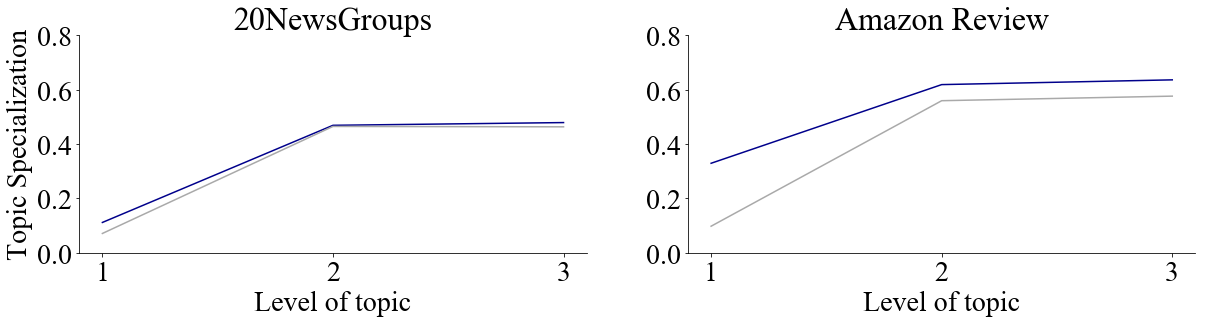

In [143]:
domain_title = {'bags': 'Amazon Review', '20news': '20NewsGroups'}
fig, (axl, axr) = plt.subplots(ncols=2, figsize=(20, 4))

def plot_topic_specialization(ax, domain, depth_specs_hntm, depth_specs_ncrp, ylabel=True):
    fontsize=28
    pd.DataFrame([depth_specs_hntm, depth_specs_ncrp], index=['TSNTM', 'nCRP']).T.plot(ax=ax, xticks=[1, 2, 3], yticks=[0.2*i for i in range(5)], fontsize=fontsize, color=['darkblue', 'darkgray'], legend=False)
    ax.set_title(domain_title[domain], fontsize=32)
    ax.set_xlabel('Level of topic', fontsize=fontsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if ylabel: ax.set_ylabel('Topic Specialization', fontsize=fontsize)

plot_topic_specialization(axl, '20news', depth_specs_20news_hntm, depth_specs_20news_ncrp)
plot_topic_specialization(axr, 'bags', depth_specs_bags_hntm, depth_specs_bags_ncrp, ylabel=False)
plt.savefig('fig/spec.pdf', bbox_inches="tight", pad_inches=0.0)

## hierarchical affinity

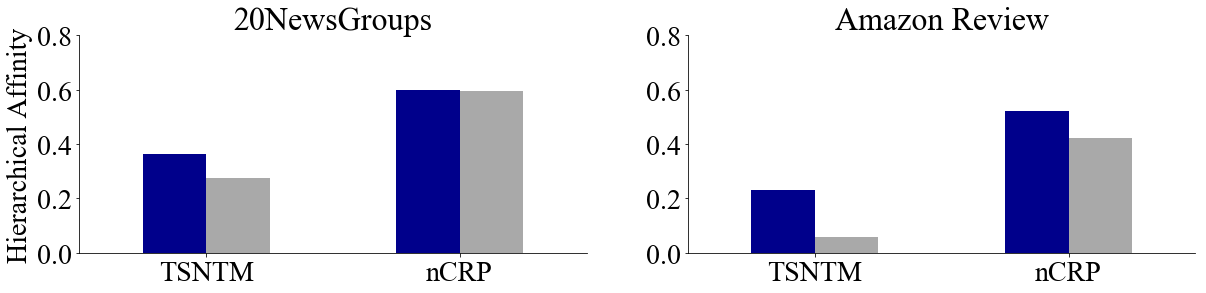

In [145]:
domain_title = {'bags': 'Amazon Review', '20news': '20NewsGroups'}
fig, (axl, axr) = plt.subplots(ncols=2, figsize=(20, 4))

def plot_topic_specialization(ax, domain, hierarchical_affinities_hntm, hierarchical_affinities_ncrp, ylabel=True):
    fontsize=28
    pd.DataFrame([hierarchical_affinities_hntm, hierarchical_affinities_ncrp], index=['TSNTM', 'nCRP'], columns=['Child', 'Non-Child']).plot.bar(ax=ax, yticks=[0.2*i for i in range(5)], fontsize=fontsize, color=['darkblue', 'darkgray'], legend=False)
    ax.set_title(domain_title[domain], fontsize=32)
    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=0, fontsize=fontsize);
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if ylabel: ax.set_ylabel('Hierarchical Affinity', fontsize=fontsize)

plot_topic_specialization(axl, '20news', hierarchical_affinities_20news_hntm, hierarchical_affinities_20news_ncrp)
plot_topic_specialization(axr, 'bags', hierarchical_affinities_bags_hntm, hierarchical_affinities_bags_ncrp, ylabel=False)
plt.savefig('fig/hier.pdf', bbox_inches="tight", pad_inches=0.0)